# Outbrain Click Prediction Kaggle Competition

_Submitted by Jay Cordes, Sarah Kelly, Nicole Lee, and Lisa Minas_

## Problem Background and Modeling Plan

Outbrain is looking to predict which ad in a given display will be clicked by a user. They have provided an extensive amount of information about where an ad is displayed, what the ad is displaying, and user activity on multiple publisher sites in the United States between 14-June-2016 and 28-June-2016. Based on this information, we are asked to order by decending probability which ad within a display a user will click. 

We plan to approach this problem in a step-wise process. First, we will explore the data to better understand what information has been provided. Based on our initial investigation, we will transform the data to fit with the machine learning models we expect to be most appropriate for predicting clicks. If we find potential value in multiple models, we will quickly score a trained model on development data to determine which model we should focus on for optimization. Once a final model is chosen, we will further refine the model and judiciously score against the development model. Our final score will be determined by testing against a provided test dataset (clicks_test) and by the score judged via Kaggle.

Note: We are running this notebook in Python3 because Kaggle uses Python3.

# Data Loading

First we load all of the datasets and save them to files we will not overwrite. These files are very large and take a while to download. To avoid re-downloading multiple times through development, we found it easiest to create copies of the original files that we could re-refer to when needing to adjust our transformations.

Based on documentation, platform and traffic_source should be 1 of three values: 1, 2, 3. We discovered through EDA that these numbers came in as both ints and strs. To clean them up, we added a dtype statement to the read_csv below.

In [2]:
# importing general libraries
import pandas as pd
import numpy as np
import copy
from matplotlib import pyplot as plt

# importing ML libraries
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# importing visual analysis 

# # Other libraries from homework 2
# SK-learn libraries for learning.
# from sklearn.pipeline import Pipeline
# from sklearn.linear_model import LogisticRegression
# from sklearn.naive_bayes import BernoulliNB
# from sklearn.naive_bayes import MultinomialNB
# from sklearn.grid_search import GridSearchCV

# # SK-learn libraries for evaluation.
# from sklearn.metrics import confusion_matrix
# from sklearn import metrics
# from sklearn.metrics import classification_report

# # SK-learn libraries for feature extraction from text.
# from sklearn.feature_extraction.text import *

In [3]:
# loading all of the files
clicks_train_og = pd.read_csv("../input/clicks_train.csv")
promoted_content_og = pd.read_csv("../input/promoted_content.csv")
doc_cats_og = pd.read_csv("../input/documents_categories.csv")
doc_ents_og = pd.read_csv("../input/documents_entities.csv")
doc_meta_og = pd.read_csv("../input/documents_meta.csv")
doc_topics_og = pd.read_csv("../input/documents_topics.csv")
events_og = pd.read_csv("../input/events.csv", dtype={'platform': str, 'geo_location': str})
page_views_og = pd.read_csv("../input/page_views_sample.csv", dtype={'platform': str, 'traffic_source': str, 'geo_location': str})
clicks_test_og = pd.read_csv("../input/clicks_test.csv")

## Data exploration

Size has turned into a major issue with this project. Outbrain provided 9 CSVs of data averaging over 100 MB in compressed form with one file that is over 2 billion rows and 100GB uncompressed. This file is so large, Outbrain provided a 10th file which is a smaller sample to use for development.

In [3]:
print("Clicks_train size is: {}".format(clicks_train_og.shape))
print("Clicks_test size is: {}".format(clicks_test_og.shape))
print("Promoted Content size is: {}".format(promoted_content_og.shape))
print("Document Categories size is: {}".format(doc_cats_og.shape))
print("Document Entities size is: {}".format(doc_ents_og.shape))
print("Document Meta size is: {}".format(doc_meta_og.shape))
print("Document Topics size is: {}".format(doc_topics_og.shape))
print("Events size is: {}".format(events_og.shape))
print("Page Views size is: {}".format(page_views_og.shape)) # note: full page views is ~100GB uncompressed

Clicks_train size is: (87141731, 3)
Clicks_test size is: (32225162, 2)
Promoted Content size is: (559583, 4)
Document Categories size is: (5481475, 3)
Document Entities size is: (5537552, 3)
Document Meta size is: (2999334, 4)
Document Topics size is: (11325960, 3)
Events size is: (23120126, 6)
Page Views size is: (9999999, 6)


First, let's explore what we're training on: clicks_train and clicks test.

In [4]:
print("Clicks_train:")
print(clicks_train_og.head())
print("\nClicks_test:")
print(clicks_test_og.head())

Clicks_train:
   display_id   ad_id  clicked
0           1   42337        0
1           1  139684        0
2           1  144739        1
3           1  156824        0
4           1  279295        0

Clicks_test:
   display_id   ad_id
0    16874594   66758
1    16874594  150083
2    16874594  162754
3    16874594  170392
4    16874594  172888


Note that test does not have the clicked label. To score our models as we build, we need to have a development set that we can predict and verify success against a known label. If we don't have a set-aside testing dataset, we'll likely overfit our model to the training data and have poorer results when scoring clicks_test and the hidden kaggle testind dataset. Therefore we will break the training data into training and development with a 70%-30% split. Otherwise, the two datasets look very similar. But display_id is the same for these first rows.

In [5]:
clicks_train_og[clicks_train_og.display_id < 4]

,display_id,ad_id,clicked
0,1,42337,0
1,1,139684,0
2,1,144739,1
3,1,156824,0
4,1,279295,0
5,1,296965,0
6,2,125211,0
7,2,156535,0
8,2,169564,0
9,2,308455,1


The first few display_ids show us that there's multiple ad_ids per display_id. Within each display_id grouping, only one ad_id is which is marked as checked. Can a single ad_id be in multiple display_ids?

In [6]:
clicks_train_og[clicks_train_og.ad_id == 250082]

,display_id,ad_id,clicked
15,3,250082,0
441,91,250082,0
550,112,250082,0
6297,1241,250082,0
7732,1526,250082,0
9539,1874,250082,0
11730,2299,250082,0
12850,2516,250082,0
14723,2878,250082,0
15398,3008,250082,0


Yes, a single ad_id can appear in many different display_ids and each ad_id can be clicked on in multiple different display_ids. To learn more about any ad_id, Outbrain says to look into promoted content.

In [7]:
promoted_content_og.head()

,ad_id,document_id,campaign_id,advertiser_id
0,1,6614,1,7
1,2,471467,2,7
2,3,7692,3,7
3,4,471471,2,7
4,5,471472,2,7


Promoted content shows which campaign_id from which advertiser_id contains the ad_id. Each campaign_id can contain multiple ad_ids. Can an ad_id be related to multiple document_ids?

In [8]:
print("Are there multiple rows per ad?: {}".format(len(promoted_content_og['ad_id'].unique()) != len(promoted_content_og)))
print("Is each document related to only one ad?: {}".format(len(promoted_content_og['document_id'].unique()) == len(promoted_content_og)))

Are there multiple rows per ad?: False
Is each document related to only one ad?: False


What is a document? Outbrain says the document_X.csv files provide context on documents as well as Outbrain's confidence in each respective relationship.

In [9]:
print("Document Categories:")
print(doc_cats_og.head())
print("\nDocument Entities:")
print(doc_ents_og.head())
print("\nDocument Topics:")
print(doc_topics_og.head())
print("\nDocument Meta:")
print(doc_meta_og.head())

Document Categories:
   document_id  category_id  confidence_level
0      1595802         1611              0.92
1      1595802         1610              0.07
2      1524246         1807              0.92
3      1524246         1608              0.07
4      1617787         1807              0.92

Document Entities:
   document_id                         entity_id  confidence_level
0      1524246  f9eec25663db4cd83183f5c805186f16          0.672865
1      1524246  55ebcfbdaff1d6f60b3907151f38527a          0.399114
2      1524246  839907a972930b17b125eb0247898412          0.392096
3      1524246  04d8f9a1ad48f126d5806a9236872604          0.213996
4      1617787  612a1d17685a498aff4f036c1ee02c16          0.386193

Document Topics:
   document_id  topic_id  confidence_level
0      1595802       140          0.073113
1      1595802        16          0.059416
2      1595802       143          0.045421
3      1595802       170          0.038867
4      1524246       113          0.196450

Docu

So each document_id can be described by a list of category_ids, entity_ids, and topic_ids. Apparently Outbrain either doesn't fully know what is in each document_id or they judge a document is mostly defined by one aspect but has influences of another. As an example: if a document talks about Brad Pitt and refers to his ex-wife as Angelina, we can say the document is 80% about Brad Pitt and 20% about Angelina. Or, alternatively, they are 80% sure the words _Brad Pitt_ refers to the person Brad Pitt and 20% sure the words _Angelina_ refers to the person Angelina Jole. Either interpretation will work for strength of relationship between a document aspect and the document.

The meta file is in a different format than the other document files. This one shows specific details on the document. Based on the documentation on Kaggle, source_id is the full home address, publisher_id is the parent of source, and publish_time is when the document was launched on the source. So, for example, webpage with address _edition.cnn.com/20160623/some_news_article/index.html_ has a source_id=edition.cnn.com, a publisher_id=cnn.com, a publish_time=June 23 2016, and a document_id=some_news_article/index.html. These values are masked by numbers, but this example helps keep it straight for us.

So we've discussed what is refered to by an ad_id and a document_id, but where does the display_id and user come into this? Remember, our final output is to rank in decending order of click probability which ad_id will be clicked within the context of a specific **display_id**, not document_id. Outbrain says events covers display context. A display in clicks_train or clicks_test means one ad from the display was clicked. Therefore, events covers all events where at least one ad was clicked.

In [10]:
events_og.tail()

,display_id,uuid,document_id,timestamp,platform,geo_location
23120121,23120122,3b42aaa4aa8993,1827718,1295999574,1,US>FL>571
23120122,23120123,7efccdc2d58fd1,2984543,1295999591,2,US>TX>623
23120123,23120124,11f9ac8cee26f2,751048,1295999657,2,US>GA>524
23120124,23120125,6bbdc5756789cc,744496,1295999771,2,US>MI>505
23120125,23120126,b545c100626cba,2357447,1295999805,2,US>SD>764


In [11]:
print('How many rows are there in events?: {:,}'.format(len(events_og)))
print('How many users are there?: {:,}'.format(len(events_og.uuid.unique())))
print('How many documents are there?: {:,}'.format(len(events_og.document_id.unique())))
print('How many displays are there?: {:,}'.format(len(events_og.display_id.unique())))

How many rows are there in events?: 23,120,126
How many users are there?: 19,794,967
How many documents are there?: 894,060
How many displays are there?: 23,120,126


In [12]:
seen = set()
dup = set()
for i in events_og.uuid:
    if i in seen:
        dup.add(i)
    seen.add(i)
events_og[events_og.uuid.isin(dup)].sort_values(by='uuid')[:20]

,display_id,uuid,document_id,timestamp,platform,geo_location
11635948,11635949,100008d45879bc,1568841,770542274,1,US>MA>506
11633862,11633863,100008d45879bc,619529,770408774,1,US>MA>506
4511731,4511732,10000a34905274,2108054,296334056,1,US>OK>650
502702,502703,10000a34905274,1798241,38774296,1,US>OK>650
11706321,11706322,10000a91d9899d,1068414,774838299,2,US>IL>602
20422639,20422640,10000a91d9899d,2834573,1160350596,2,US
7756431,7756432,10000e5327e96b,2258308,537705911,3,US>UT>770
4143201,4143202,10000e5327e96b,2066958,264990674,3,US>UT>770
12461877,12461878,10000f9ed3fb23,2592689,827245270,2,US>CA>803
12466117,12466118,10000f9ed3fb23,2592689,827433223,2,US>CA>803


The same user can be shown multiple different displays, but this happens rarely and display_id is unique per user_id * document_id. A display_id is associated with multiple documents which we interpret as a document can be pointed to by multiple displays. But since an ad does the actual pointing, an ad can appear in different displays and point to the same document. This is all pretty confusing so here's a diagram to help:

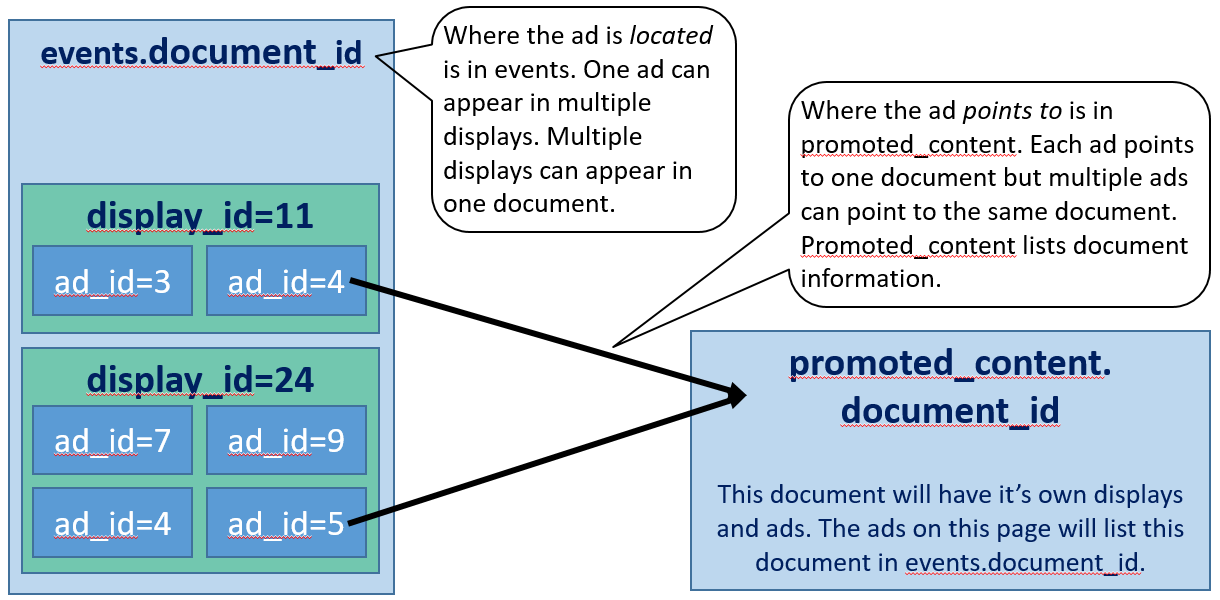

In [13]:
from IPython.display import Image
Image(filename='relationship_diagram.png')

Anything interesting about the users in page_views?

In [14]:
page_views_og.head()

,uuid,document_id,timestamp,platform,geo_location,traffic_source
0,1fd5f051fba643,120,31905835,1,RS,2
1,8557aa9004be3b,120,32053104,1,VN>44,2
2,c351b277a358f0,120,54013023,1,KR>12,1
3,8205775c5387f9,120,44196592,1,IN>16,2
4,9cb0ccd8458371,120,65817371,1,US>CA>807,2


Notice that clicks are not mentioned here. This indicates page_views is about _any_ page view, not just the ones with a 'success' of a click. Hence the full page_views file is 100GB - there were a lot of documents viewed that never received a click.

## Data joining

Now that we know what we have, it's time to join the data. The relationships are complicated due to potential multiple joins and document_id having two different definitions depending on which table it comes from. Therefore, we join tables in a step-wise fashion, checking that the key field per tale is included as we build up our working dataset. Please see inline comments for what happens at each step.

In [4]:
# Documents are highest level item in the dataset.
# To find the full set of documents covered by our datasets, 
# pull in the documents that are in both page_views and promoted_content.
doc_ids = set(page_views_og['document_id']) & set(promoted_content_og['document_id'])

# To only view displays and ads that are on our 'master' document list,
# filter events to documents that are found in page_views and promoted_content.
events = events_og[events_og['document_id'].isin(doc_ids)]

# We only want to view ad clicks for displays that have document information.
# So we filter clicks to displays found in events.
clicks_train = clicks_train_og[clicks_train_og['display_id'].isin(events['display_id'])]
clicks_test = clicks_test_og[clicks_test_og['display_id'].isin(events['display_id'])]

# Because clicks may not cover all displays shown in events,
# re-filter events to display_id's that are found in clicks_train.
events = events_og[events_og['display_id'].isin(clicks_train['display_id'])]

# By this point we have a solid list of ads, displays, and documents found in our activity files.
# Now filter promoted content to ads found in the filtered training dataset for model fitting.
promoted_content = promoted_content_og[promoted_content_og['ad_id'].isin(clicks_train['ad_id'])]

# We only need document information about documents we are still considering after prior filters.
# Filter document content files to only documents that have made it through to promoted_content for space reasons.
doc_cats = doc_cats_og[doc_cats_og['document_id'].isin(promoted_content['document_id'])]
doc_ents = doc_ents_og[doc_ents_og['document_id'].isin(promoted_content['document_id'])]
doc_meta = doc_meta_og[doc_meta_og['document_id'].isin(promoted_content['document_id'])]
doc_topics = doc_topics_og[doc_topics_og['document_id'].isin(promoted_content['document_id'])]

# Similarly, filter page views to documents found in events to make this file manageable.
page_views = page_views_og[page_views_og['document_id'].isin(events['document_id'])]

# Data Transformation

Based on our EDA, we are planning to fit models INSERT WHAT WE ARE DOING HERE AND WHY.

## Transforming the training dataset

In [5]:
# first, format the training dataset

def click_percent(dataset, ad_id, default_result, reg):
    '''Returns the posterior probability of ad being clicked.
    If ad has not been encountered before, assume mean click'''
    
    # count number of times ad has been seen
    ad_total = len(dataset[dataset['ad_id'] == ad_id])
    
    # if ad has not been seen, returned the default_results
    if ad_total == 0:
        return default_result
    # otherwise return percentage of times ad has been clicked, adjusted by a regularization term
    else:
        click_sum = np.sum(dataset[dataset['ad_id'] == ad_id].clicked) + 1.0
        return click_sum / (ad_total + reg)

# Merging information aout the displays to master dataset
data = clicks_train.merge(events, on='display_id', how='left')
# joins information about the display that the user saw
# each display has a unique user id, doc id, and timestamp
# events has the information about the display (who the user is, which site (document_id) it was on, when it was seen, from where, etc.)

# Identifying which documents the ads refer to (aka destination documents)
data = data.merge(promoted_content, on='ad_id', how='left')

# Gather/bin data about the documents the ads refer to
sparsetop = doc_topics.pivot(index='document_id', columns='topic_id', values='confidence_level')
sparsetop.columns = ['top_' + str(col) for col in sparsetop.columns]

sparsecat = doc_cats.pivot(index='document_id', columns='category_id', values='confidence_level')
sparsecat.columns = ['cat_' + str(col) for col in sparsecat.columns]

sparse = sparsetop.join(sparsecat, how='outer')
sparse.fillna(0, inplace=True)

sparse.reset_index(level=0, inplace=True)

data = data.merge(sparse, left_on='document_id_y', right_on='document_id', how='left')

# adding in advertiser information
advr_success = dict(zip(data.advertiser_id.unique(),
                        [sum(data[data['advertiser_id']==x]['clicked'])/len(data[data['advertiser_id']==x]) for x in data['advertiser_id'].unique()]))
data['advertiser_perc'] = data['advertiser_id'].map(advr_success)

# adding in campagin information
camp_success = dict(zip(data.campaign_id.unique(), 
                        [sum(data[data['campaign_id']==x]['clicked'])/len(data[data['campaign_id']==x]) for x in data['campaign_id'].unique()]))
data['campaign_perc'] = data['campaign_id'].map(camp_success)

# adding in meta about document view frequencies
doc_view_freq = dict(zip(page_views.document_id.unique(), [len(page_views[page_views.document_id==x]) for x in page_views.document_id.unique()]))
data['docx_view_freq'] = data['document_id_x'].map(doc_view_freq)

# Adding meta data about prior click percentage
mean_click = np.mean(data["clicked"])
click_success = dict(zip(data.ad_id.unique(), [click_percent(data, x, mean_click, 10.0) for x in data["ad_id"].unique()] ))
data['click_perc'] = data['ad_id'].map(click_success)

data.head()

,display_id,ad_id,clicked,uuid,document_id_x,timestamp,platform,geo_location,document_id_y,campaign_id,...,cat_2002,cat_2003,cat_2004,cat_2005,cat_2006,cat_2100,advertiser_perc,campaign_perc,docx_view_freq,click_perc
0,37,70153,0,d4f62cdcb39ad8,1779285,2687,2,US>WA>819,933716,7516,...,0.0,0.0,0.0,0.0,0.0,0.0,0.046069,0.045455,7701,0.052632
1,37,149047,0,d4f62cdcb39ad8,1779285,2687,2,US>WA>819,1169985,16636,...,0.0,0.0,0.0,0.0,0.0,0.0,0.137931,0.137931,7701,0.076923
2,37,169564,0,d4f62cdcb39ad8,1779285,2687,2,US>WA>819,1394819,20109,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,7701,0.071429
3,37,234713,1,d4f62cdcb39ad8,1779285,2687,2,US>WA>819,1586431,245,...,0.0,0.0,0.0,0.0,0.0,0.0,0.271255,0.265217,7701,0.281250
4,37,235443,0,d4f62cdcb39ad8,1779285,2687,2,US>WA>819,1377696,11654,...,0.0,0.0,0.0,0.0,0.0,0.0,0.082631,0.043478,7701,0.043478


## Formatting testing dataset

In [6]:
# Pull from full events_og to make sure all display information is gathered
data_test = clicks_test.merge(events_og, on='display_id', how='left')

# find the ads from the entire promoted_content_og data and not the one filtered on clicks_train
data_test = data_test.merge(promoted_content_og, on='ad_id', how='left')

# matching top_X and cat_X categories from training to test. Sparse was created while developing the training dataset
data_test = data_test.merge(sparse, left_on='document_id_y', right_on='document_id', how='left')

# Adding meta data from training
data_test['docx_view_freq'] = data_test['document_id'].map(doc_view_freq)
data_test['campaign_perc'] = data_test['campaign_id'].map(camp_success)
data_test['advertiser_perc'] = data_test['advertiser_id'].map(advr_success)
data_test['click_perc'] = data_test['ad_id'].map(click_success)

# fill any nas so the modeling won't get wonky
data_test.fillna(0, inplace=True)
# check if there are any missing columns between the two datasets

missing_col = set(data_test.columns) ^ set(data.columns)
print(missing_col)

# only one missing, clicked. But that's ok because we're going to take clicked out to make a training and development set for modeling

{'clicked'}


## Splitting training into train and development

In [7]:
def split_train_dev(dataset, train_percent = 0.7):
    '''Splitting data into test and dev.
    If train_precent is left at default, 70% will go into training and 30% into development.
    If train_percent = 1, all data will go into training.
    If train_percent = 0, all data will go into development.'''

    labels = data['clicked']
    labels = labels.values.reshape(-1,1)

    print ('Labels length:', len(labels))
    print ('data length:', data.shape)
    print ('')
        
    train_data = data[:int(train_percent*len(data))].drop('clicked', 1)
    dev_data = data[int(train_percent*len(data)):].drop('clicked', 1)

    train_labels = labels[:int(train_percent*len(data))]
    dev_labels = labels[int(train_percent*len(data)):]

    print ('training label shape:', train_labels.shape)
    print ('training data shape:', train_data.shape)
    print ('test label shape:', dev_labels.shape)
    print ('test data shape:', dev_data.shape)
    
    return train_data, train_labels, dev_data, dev_labels

train_data, train_labels, dev_data, dev_labels = split_train_dev(data, train_percent = 0.7)

Labels length: 282205
data length: (282205, 411)
training label shape: (197543, 1)
training data shape: (197543, 410)
test label shape: (84662, 1)
test data shape: (84662, 410)


So now we have three datasets
1. train_data, train_labels = 70% of clicks_train dataset. Used for training models.
2. dev_data, dev_labels = remaining 30% of clicks_train dataset. Used for measuring accuracy of models on non-train data.
3. test_data = clicks_test dataset for final scoring of model.

In [ ]:
# to print any of these datasets to csv, uncomment the appropriate line

# data_test.to_csv('testingdata.cvs',index=False)

# data.to_csv('fulltrainingdata.cvs',index=False)

# train_data.to_csv('trainingdata.cvs',index=False)
# train_labels.to_csv('traininglabels.cvs',index=False)

# dev_data.to_csv('developmentdata.cvs',index=False)
# dev_labels.to_csv('developmentlabels.cvs',index=False)

# Following Homework2

In [17]:
data_test.columns[11:]
#train_data.columns[11:]

Index(['top_0', 'top_1', 'top_2', 'top_3', 'top_4', 'top_5', 'top_6', 'top_7',
       'top_8', 'top_9',
       ...
       'cat_2002', 'cat_2003', 'cat_2004', 'cat_2005', 'cat_2006', 'cat_2100',
       'docx_view_freq', 'campaign_perc', 'advertiser_perc', 'click_perc'],
      dtype='object', length=399)

# running on real clicks_test data

In [23]:
#train_data_full, train_labels_full, dev_data_full, dev_labels_full = split_train_dev(data, train_percent = .99)

# fit a logistic regression on the numerical information from train_data
lr = LogisticRegression()
lr.fit(train_data[train_data.columns[11:]].fillna(0), train_labels.reshape([1,-1]) )

# # this line outputs predictions on the dev data
# lr_click_prob = lr.predict_proba(dev_data[dev_data.columns[11:]].fillna(0))[:,1]
# # scores
# lr_score = lr.score(test_data[test_data.columns[5:]].fillna(0), test_labels)

lr_click_prob = pd.DataFrame({'display_id': data_test['display_id'],
                              'ad_id': data_test['ad_id'],
                              'prediction': lr.predict_proba(data_test[data_test.columns[11:]].fillna(0))[:,1]
                             })

C:\Users\lisam\Anaconda2\envs\py35\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [40]:
# sort predictions
lr_click_prob.sort_values(by=['display_id','prediction'], ascending=False, inplace=True)

# Format the data the way the submission requires
output=lr_click_prob.groupby(['display_id'])['ad_id'].apply(lambda x:' '.join(map(str,x))).reset_index()

# That's it for the simple solution (prior expectation)!
output.to_csv('submission_20161211_1313.cvs',index=False)

    ad_id  display_id  prediction
4  228959    16875069    0.164374
2  132857    16875069    0.107699
3  153427    16875069    0.077669
5  328479    16875069    0.065585
0   57252    16875069    0.047405
1   61159    16875069    0.039304


,display_id,ad_id
0,16875069,228959 132857 153427 328479 57252 61159
1,16875211,86615 78011 265795 184170 289102 182353 83747 ...
2,16875636,111199 78011 265795 95129 182353 83747 298163 ...
3,16875780,230212 146172 85576 38617 241057 11522 78499 1...
4,16876531,65501 88733 270253 78011 118874 279893 151954 ...


# Appendix/Working space - this is stuff that hasn't been added to the 'full' run.
### AKA Lisa's stuff that might go somewhere or might be dumped.

### Lost comments
** The below are all good comments that have become detached from their original location, probably from Lisa creating the dataload.py. Keeping them here for now so that they can be reattached as we work on formating the final notebook.**

---

Now we are merging information on what documents the ads referred to (from source: promoted_content).  
In every display, there are multiple ads (within one document = document_id_x). Every ad refers to a different document, which is the site the ad is promoting (document_id_y). All the columns after document_id_y are information about that document (to which the ad is referring).

---

### Merge information about the documents the ads refer to
All the doc files have information about the documents (websites) to which the ads refer to
including confidence levels of which topics the ads referred to, which categories they're apart of, etc.

We wanted to duplicate the idea of the CountVectorizer for the 'bag of words' model we used for spam detection, but since we're not counting words in a text, it's a little bit different. Since we have a 'dictionary' of categories and topics, we use that as our 'vocabulary.' Every document has a confidence level for one or more items in the vocabulary, so we create a sparse matrix with every topic and category as columns, and every document has a confidence level value in the respective columns. If they are not given a confidence level, we put 0 because the document most likely does not have anything to do with that category or topic (given the data provided by Outbrain).

This data on the documents will help us separate ads from one another based on topic/category.  
ie) why did ad A get clicked instead of ad B? We know ad A referred to document 1 whereas ad B referred to document 2, and now we have general information about the documents the ads referred to. We will merge this information in later steps.

---

creating dictionaries for % of ads clicked for every advertiser and campaign.  
purpose: merge to master dataset as a feature for every ad, how often the advertiser and campaign are successful on average.

---

Add count of page views to every document that an ad appears in (document_id_x) as a feature, could tell us something about likelihood of ads being clicked

In [ ]:
# #################3 IGNORE THIS#############3

# # events['country'], events['state'] = zip(*map(lambda x: str(x).split('>'), list(events['geo_location'])))

# # #temp = map(lambda x: str(x).split('>'), list(page_views['geo_location']))
# # print temp[:5]
# # zip(*temp[:5]) # removes DMA

# #events2 = pd.DataFrame(events['geo_location'].str.split(',').tolist(), columns = ['country', 'state', 'dma'])
# events['geo_location'].str.split('>', expand= True)
# geo = map(lambda x: str(x).split('>'), events['geo_location'])
# zip(*geo)
# country = [x[0] for x in geo]
# #state = [x[1] for x in geo if x[1]]
# if None:
#     print('a')

In [8]:
def lr_prediction(train_data, train_labels, test_data, test_labels):
    '''Returns the array of display_id, ad_id and probability it will be clicked'''
    lr = LogisticRegression()
    lr.fit(train_data[train_data.columns[11:]].fillna(0), train_labels)
    lr_click_prob = lr.predict_proba(test_data[test_data.columns[11:]].fillna(0))[:,1]
    lr_score = lr.score(test_data[test_data.columns[11:]].fillna(0), test_labels)
    return pd.DataFrame({'display_id': test_data['display_id'],
                         'ad_id': test_data['ad_id'],
                         'prediction': lr_click_prob
                        })
lr_output = lr_prediction(train_data, train_labels, dev_data, dev_labels)

C:\Users\lisam\Anaconda2\envs\py35\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
